In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math, scipy, skimage, os
import matplotlib as mpl
import seaborn as sns

mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['font.size'] = 7
mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['pdf.fonttype'] = 42

mpl.rcParams['axes.linewidth'] = 0.5
mpl.rcParams['xtick.major.width'] = 0.5
mpl.rcParams['ytick.major.width'] = 0.5
mpl.rcParams['xtick.minor.width'] = 0.5
mpl.rcParams['ytick.minor.width'] = 0.5
mpl.rcParams['xtick.major.size'] = 2.5
mpl.rcParams['ytick.major.size'] = 2.5

In [4]:
replicates_info = pd.read_excel('B:\home\Xin home drive\data_meroblastic\\majority_data_info.xlsx')
replicates_info = replicates_info[replicates_info['geometry']=='yes'].reset_index()
replicates_info

<>:1: SyntaxWarning: invalid escape sequence '\h'
<>:1: SyntaxWarning: invalid escape sequence '\h'
C:\Users\xtong\AppData\Local\Temp\ipykernel_12068\4199784578.py:1: SyntaxWarning: invalid escape sequence '\h'
  replicates_info = pd.read_excel('B:\home\Xin home drive\data_meroblastic\\majority_data_info.xlsx')


,index,rep,experiment,Unnamed: 2,embryo,type,Unnamed: 5,time_interval,pixel_size,voxel_depth,...,ck3,staging,furrow_indentation,correction,contact_angle,contact_angle_parameters,cortical_actin_intensity_quanti,cortical_actin_intensity_quanti1,cortical_actin_intensity_quanti2,geometry
0,0,1,actin\wt_confocal\XIN210821_LSM9001_DCLKegfp_U...,NaN,e1,geometry,NaN,46.85,1.2479,3.0,...,77,wt,wt,NaN,wt,"wt (0, 1)",3.0,14.0,48.0,yes
1,1,2,actin\wt_confocal\XIN210821_LSM9001_DCLKegfp_U...,NaN,e2,geometry,NaN,46.93,1.2479,3.0,...,78,wt,wt,NaN,wt,"wt (0, 1)",2.0,16.0,50.0,yes
2,2,3,actin\wt_confocal\XIN210822_LSM9001_DCLKegfp_U...,NaN,e1,geometry,best ever,47.00,1.2479,3.0,...,79,wt,wt,NaN,wt,"wt (0, 1)",2.0,18.0,52.0,yes
3,3,4,actin\wt_confocal\XIN210822_LSM9001_DCLKegfp_U...,NaN,e2,NaN,NaN,47.00,1.2479,3.0,...,84,wt,wt,NaN,wt,"wt (0, 1)",2.0,19.0,54.0,yes
4,4,5,actin\wt_confocal\XIN210727_LSM9001_DCLKegfp_U...,NaN,e1,NaN,NaN,89.55,1.2479,3.0,...,37,wt,wt,NaN,wt,"wt (0, 1)",2.0,5.0,24.0,yes
5,5,6,actin\wt_confocal\XIN210727_LSM9001_DCLKegfp_U...,NaN,e2,NaN,NaN,89.53,1.2479,1.5,...,41,wt,wt,NaN,wt,"wt (0, 1)",2.0,8.0,27.0,yes
6,6,7,actin\wt_confocal\XIN210510_LSM9001_LSM8002_DC...,NaN,e1,NaN,NaN,41.28,1.2479,3.0,...,94,wt,wt,NaN,wt,"wt (2, 1)",2.0,16.0,60.0,yes
7,8,9,actin\wt_confocal\XIN210510_LSM9001_LSM8002_DC...,NaN,e3,NaN,NaN,50.38,1.2479,3.0,...,84,wt,wt,NaN,wt,"wt (2, 1)",2.0,12.0,51.0,yes
8,25,26,membrane\XIN220609_LSM9001_mCherryCAAX,NaN,e1,NaN,NaN,92.70,1.2479,1.5,...,NaN,wt,wt,NaN,wt,"wt (2, 1)",NaN,NaN,NaN,yes


### Phase 2 membrane septum tip position

In [7]:
# curve length

def calculate_curve_length(points):
    """
    Calculate the length of a 3D curve given as an (N, 3) NumPy array.
    
    Parameters:
        points (np.ndarray): An array of shape (N, 3) representing the curve.
    
    Returns:
        float: The total arc length of the curve.
    """
    diffs = np.diff(points, axis=0)
    segment_lengths = np.linalg.norm(diffs, axis=1)
    return np.sum(segment_lengths)

In [8]:
def fit_arc_3d(points):
    """
    Fits a 3D circular arc to a series of points, ensuring the arc passes
    through the first and last points.

    Args:
        points (list or np.ndarray): A list of 3D points [x, y, z].
                                     Shape (n_points, 3).

    Returns:
        dict: A dictionary containing the parameters of the fitted arc:
              'center' (np.ndarray): 3D center of the circle.
              'radius' (float): Radius of the circle.
              'normal' (np.ndarray): Normal vector of the plane of the circle.
              'start_angle' (float): Start angle of the arc in radians.
              'end_angle' (float): End angle of the arc in radians.
              'basis_u' (np.ndarray): First basis vector of the circle's plane.
              'basis_v' (np.ndarray): Second basis vector of the circle's plane.
    """

    import numpy as np
    from scipy.optimize import minimize_scalar

    points = np.asarray(points)
    if points.shape[1] != 3:
        raise ValueError("Input points must be 3D.")
    if len(points) < 3:
        raise ValueError("At least 3 points are required.")

    # --- 1. Find the best-fit plane using PCA ---
    centroid = np.mean(points, axis=0)
    # Use SVD to find the normal vector (eigenvector of the smallest eigenvalue)
    _, _, vh = np.linalg.svd(points - centroid)
    plane_normal = vh[2, :]
    # Ensure the normal vector points towards the "average" side of the points
    # This helps in creating a consistent coordinate system
    if np.dot(plane_normal, np.mean(points[1:-1] - points[0], axis=0)) < 0:
        plane_normal = -plane_normal

    # --- 2. Create a 2D coordinate system on the plane ---
    # The first basis vector is from the last to the first point
    basis_u = points[-1] - points[0]
    if np.linalg.norm(basis_u) < 1e-6:
        # If start and end points are the same, use another vector on the plane
        basis_u = points[1] - points[0]
    basis_u /= np.linalg.norm(basis_u)
    basis_v = np.cross(plane_normal, basis_u)
    
    # --- 3. Project 3D points to 2D coordinates ---
    points_2d = np.zeros((len(points), 2))
    for i, p3d in enumerate(points):
        p_rel = p3d - points[0] # Project relative to the first point
        points_2d[i, 0] = np.dot(p_rel, basis_u)
        points_2d[i, 1] = np.dot(p_rel, basis_v)

    p0 = points_2d[0]
    pn = points_2d[-1]
    pi = points_2d[1:-1]

    # --- 4. Find the best-fit 2D circle with constraints ---
    # The center of the circle must lie on the perpendicular bisector
    # of the segment p0-pn.
    mid_point = (p0 + pn) / 2
    d_vec = pn - p0
    # The direction of the bisector is perpendicular to d_vec
    bisector_dir = np.array([-d_vec[1], d_vec[0]])
    if np.linalg.norm(bisector_dir) < 1e-9:
        # This happens if p0 and pn are the same point after projection.
        # This case is degenerate, we can't form a unique circle.
        # Returning None as a signal of failure.
        print("Warning: Start and end points are projected to the same location.")
        return None
        
    bisector_dir /= np.linalg.norm(bisector_dir)

    # Objective function to minimize. 't' is the distance along the bisector.
    def error_func(t):
        center = mid_point + t * bisector_dir
        radius = np.linalg.norm(p0 - center)
        if radius < 1e-9:
            return np.inf
        # Sum of squared geometric distances from intermediate points to the circle
        distances = np.linalg.norm(pi - center, axis=1)
        errors = (distances - radius)**2
        return np.sum(errors)

    # Find the optimal t that minimizes the error
    res = minimize_scalar(error_func)
    t_opt = res.x

    # --- 5. Reconstruct the circle parameters ---
    center_2d = mid_point + t_opt * bisector_dir
    radius = np.linalg.norm(p0 - center_2d)

    # Convert 2D center back to 3D
    center_3d = points[0] + center_2d[0] * basis_u + center_2d[1] * basis_v

    # --- 6. Determine arc angles (Corrected Logic) ---
    vec_start = p0 - center_2d
    vec_end = pn - center_2d
    
    angle_start = np.arctan2(vec_start[1], vec_start[0])
    angle_end = np.arctan2(vec_end[1], vec_end[0])

    # Ensure the arc travels in the direction of the intermediate points.
    # We check if the average intermediate point lies in the counter-clockwise
    # sweep from start to end. If not, we must sweep the other way (clockwise).
    if len(pi) > 0:
        avg_intermediate_vec = np.mean(pi, axis=0) - center_2d
        avg_angle = np.arctan2(avg_intermediate_vec[1], avg_intermediate_vec[0])
        
        # Calculate the counter-clockwise sweep from start to end
        sweep_ccw = (angle_end - angle_start + 2 * np.pi) % (2 * np.pi)
        # Calculate the counter-clockwise sweep from start to the average intermediate point
        sweep_to_avg = (avg_angle - angle_start + 2 * np.pi) % (2 * np.pi)

        # If the sweep to the average point is greater than the sweep to the end point,
        # it means the average point is "behind" the end point in the CCW direction.
        # This implies the correct path is clockwise.
        if sweep_to_avg > sweep_ccw:
             # To sweep clockwise, we can swap the start and end angles.
             angle_start, angle_end = angle_end, angle_start

    # Always produce a positive (counter-clockwise) sweep from the determined start to end.
    if angle_end < angle_start:
        angle_end += 2 * np.pi

    fit_result = {"center": center_3d,
        "radius": radius,
        "normal": plane_normal,
        "start_angle": angle_start,
        "end_angle": angle_end,
        "basis_u": basis_u,
        "basis_v": basis_v,
    }

    center = fit_result['center']
    radius = fit_result['radius']
    start_angle = fit_result['start_angle']
    end_angle = fit_result['end_angle']
    basis_u = fit_result['basis_u']
    basis_v = fit_result['basis_v']

    theta = np.linspace(start_angle, end_angle, 100)
    arc_points = center[:, np.newaxis] + radius * (np.cos(theta) * basis_u[:, np.newaxis] + np.sin(theta) * basis_v[:, np.newaxis])

    return arc_points

In [40]:
from scipy.optimize import leastsq, least_squares


def fit_circle_3d(points):
    # Step 1: Fit a plane via SVD
    centroid = points.mean(axis=0)
    U, S, Vt = np.linalg.svd(points - centroid)
    normal = Vt[2, :]

    # Step 2: Project points onto the plane
    def project_point(p):
        return p - np.dot(p - centroid, normal) * normal

    projected = np.array([project_point(p) for p in points])

    # Step 3: Define 2D coordinate system on the plane
    u = Vt[0, :]
    v = Vt[1, :]

    x = np.dot(projected - centroid, u)
    y = np.dot(projected - centroid, v)

    # Step 4: Fit circle in 2D
    def calc_R(xc, yc):
        return np.sqrt((x - xc)**2 + (y - yc)**2)

    def residuals(c):
        Ri = calc_R(*c)
        return Ri - Ri.mean()

    center_estimate = (0, 0)
    result = least_squares(residuals, center_estimate)

    center_2d = result.x
    radius = calc_R(*center_2d).mean()

    # Step 5: Map center back to 3D
    center_3d = centroid + center_2d[0]*u + center_2d[1]*v

    return center_3d, normal, radius


def fit_circle_2d(points):
    
    # Compute the initial guess for the center
    x_m, y_m = np.mean(points, axis=0)
    
    def calc_R(xc, yc):
        """Calculate distance of each point from the center (xc, yc)."""
        return np.sqrt((points[:, 0] - xc)**2 + (points[:, 1] - yc)**2)
    
    def f_2(c):
        """Calculate algebraic distance between data points and mean circle."""
        Ri = calc_R(*c)
        return Ri - Ri.mean()
    
    # Initial guess for the center
    center_estimate = (x_m, y_m)
    center, _ = leastsq(f_2, center_estimate)
    xc, yc = center
    
    # Compute the radius as the mean distance to the center
    R = calc_R(xc, yc)
    r = R.mean()
    
    return xc, yc, r

rep 1
actin\wt_confocal\XIN210821_LSM9001_DCLKegfp_UtrmCherry__Animal__1cell
[ 80.93615441 129.55143856 142.48420755 167.90252175 202.36970506
 217.26702465 201.28654546 238.4814902  251.71482446]
[ 80.88279542 129.47298644 142.39869365 167.86060387 202.25988595
 217.12550113 201.25590789 238.41214554 251.59492566]


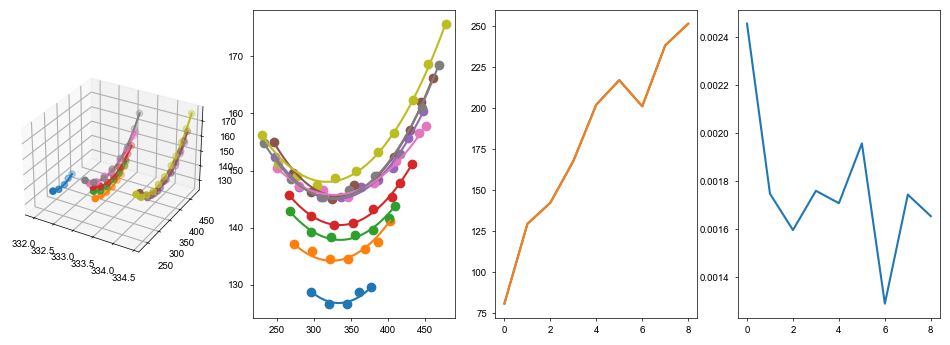

rep 2
actin\wt_confocal\XIN210821_LSM9001_DCLKegfp_UtrmCherry__Animal__1cell
[ 35.69998009  64.65954805  87.46052159 115.99220378 134.20653881
 140.49582479 153.34661635 167.86492967]
[ 35.71956991  64.67759749  87.43869714 116.00811685 134.09795471
 140.40653602 153.29633206 167.78201854]


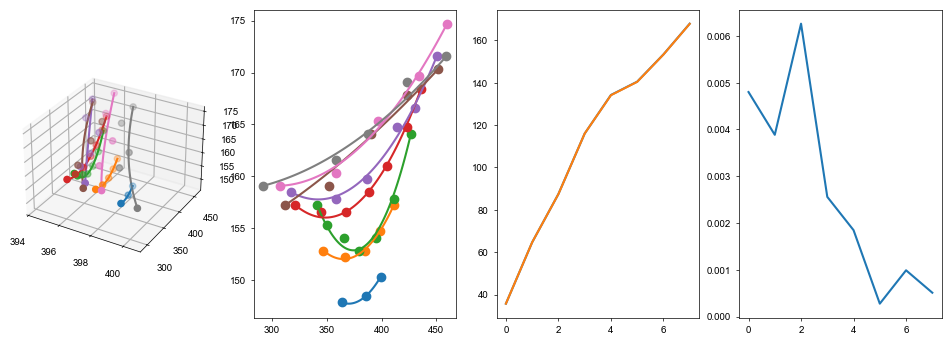

rep 3
actin\wt_confocal\XIN210822_LSM9001_DCLKegfp_UtrmCherry__Animal__1cell
[ 12.49359276  20.67492404  50.20878379  87.91768859 118.45154078
 148.71836774 162.01783062 186.38060162 217.13037236 220.96326322]
[ 12.49359276  20.67492404  50.26041079  87.83451068 117.75662377
 148.60658795 161.76193237 186.21963147 216.79863095 220.53005555]


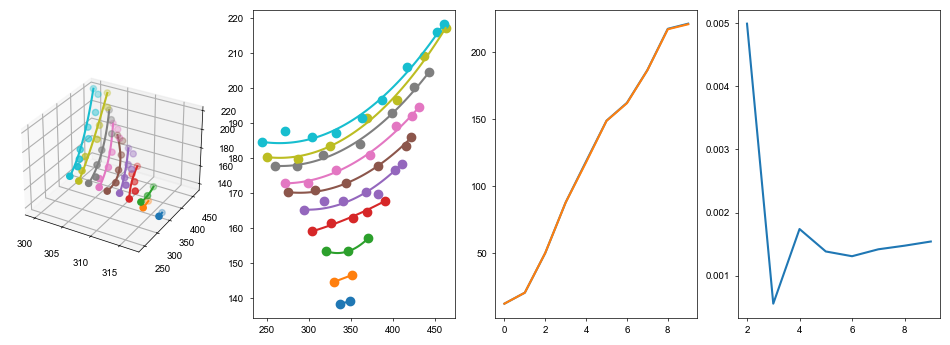

rep 4
actin\wt_confocal\XIN210822_LSM9001_DCLKegfp_UtrmCherry__Animal__1cell
[  7.799        9.69151326  30.85010559  42.49352984  68.90817925
  59.79875064  94.11505223 105.32252938 113.85277134 119.51524296
 134.66127847]
[  7.799        9.671       30.83613069  42.48388322  68.85600426
  59.78780727  94.08261395 105.19297892 113.36429274 118.95947954
 134.1244545 ]


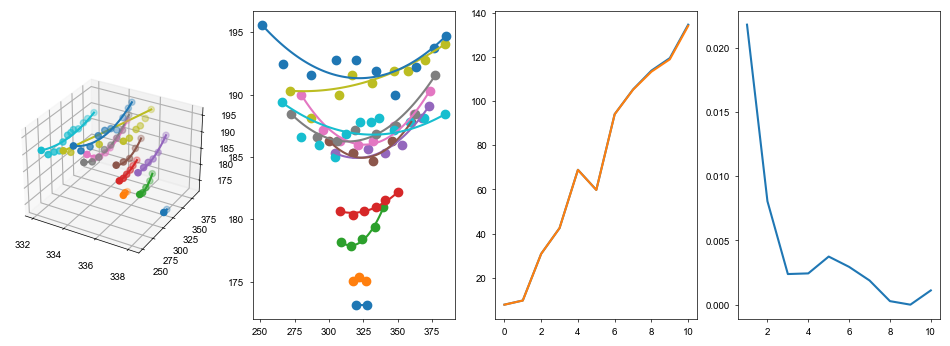

rep 5
actin\wt_confocal\XIN210727_LSM9001_DCLKegfp_UtrmCh__Animall__1cell
[ 25.5832672   79.05733961 103.38127839 155.2152556  215.55211477
 279.20507186]
[ 25.5840065   78.95977557 103.36670838 154.94444924 215.48095006
 278.70414518]


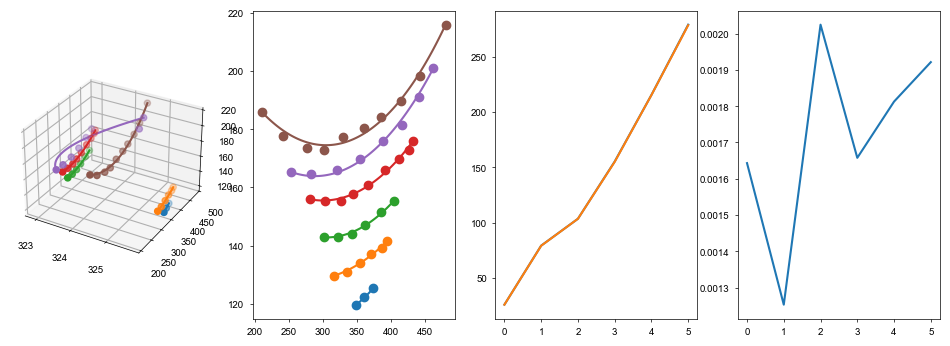

rep 6
actin\wt_confocal\XIN210727_LSM9001_DCLKegfp_UtrmCh__Animall__1cell
[ 90.04894073 120.03805097 204.42028574 237.59597049 243.06496459]
[ 90.03297344 119.91002261 203.51115311 237.25334281 242.15122211]


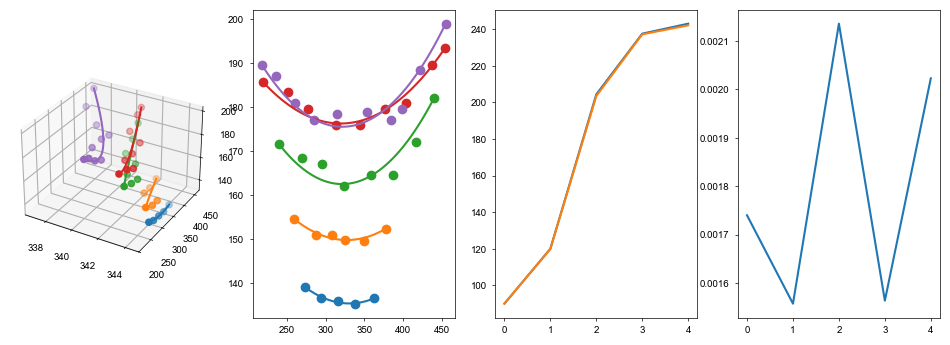

rep 7
actin\wt_confocal\XIN210510_LSM9001_LSM8002_DCLKegfp_UtrmCherry__Animal__1cell__zoom0p5
[155.89217876 173.88403662 195.26553803 191.61280971 235.16654518
 242.32886456 265.47884866 267.71073342]
[155.83650835 173.79518564 191.63409654 191.28380284 234.83531351
 241.76419386 265.35361387 266.90431804]


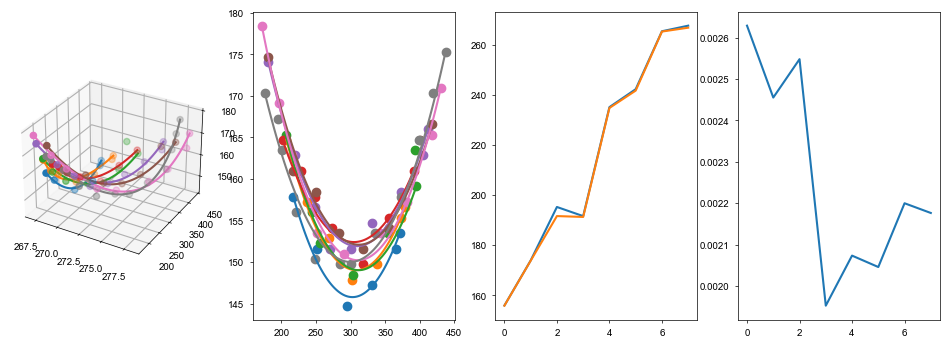

rep 9
actin\wt_confocal\XIN210510_LSM9001_LSM8002_DCLKegfp_UtrmCherry__Animal__1cell__zoom0p5
[  7.487       42.55916535  78.51939155  82.06081087 117.94164094
 122.97716042 136.71875917 140.0993552  141.9691628 ]
[  7.487       42.49335696  78.37627431  82.01578076 117.52100833
 122.73054273 136.62231961 139.58674579 141.53846861]


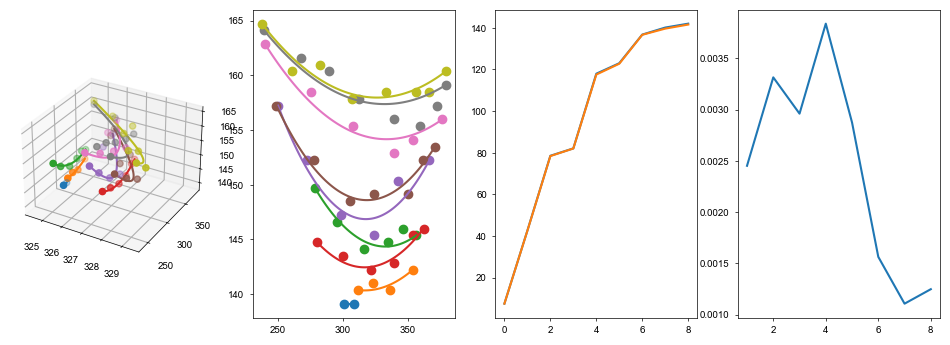

rep 26
membrane\XIN220609_LSM9001_mCherryCAAX
[164.03911851 192.75483844 224.60384392 243.84929117 255.93183064
 287.61161459]
[164.00611047 192.66302294 224.27455782 243.42740645 255.70056101
 286.88462162]


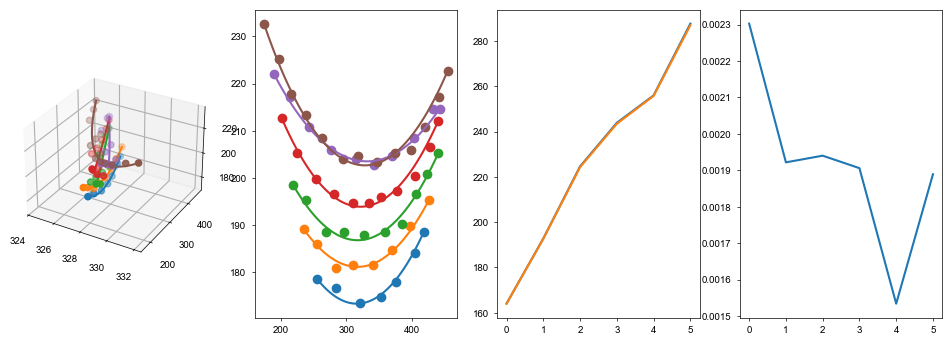

In [48]:
from scipy.optimize import curve_fit

mem_septum_tip_phase2_lengths = []
mem_septum_tip_phase2_curvs = []


for i in replicates_info.index:
# for i in [2]:
    replicate = replicates_info.loc[i]
    print('rep', replicate.rep)
    print(replicate.experiment)
    pixel_size = replicate.pixel_size
    mem_septum_tip_phase2 = 'rep' + str(replicate.rep) + '\\mem_septum_tip_phase2.csv'
    mem_septum_tip_phase2 = pd.read_csv(mem_septum_tip_phase2)
    mem_septum_tip_phase2_frames = mem_septum_tip_phase2['Frame'].unique()
    mem_septum_tip_phase2_frames = np.sort(mem_septum_tip_phase2_frames)

    mem_septum_tip_phase2_length = []
    mem_septum_tip_phase2_length2 = []
    mem_septum_tip_phase2_curv = []

    fig = plt.figure(figsize=[12,4])
    ax = fig.add_subplot(1,4, 1, projection='3d')
    ax1 = fig.add_subplot(1,4, 2)
    ax2 = fig.add_subplot(1,4, 3)
    ax3 = fig.add_subplot(1,4, 4)

    for f in mem_septum_tip_phase2_frames:

        subset = mem_septum_tip_phase2[mem_septum_tip_phase2['Frame'] == f]
        subset = subset.sort_values(['X','Slice'])
        xx, yy, zz= subset['Slice']*pixel_size, subset['X'], subset['Y']

        ax.scatter(xx,yy,zz)
        ax1.scatter(yy, zz)

        if len(xx)>= 3:
            arc_points_new = fit_arc_3d(np.array([xx,yy,zz]).T)
            xxnew, yynew, zznew = arc_points_new            
        else:
            xxnew, yynew, zznew = xx, yy, zz

        
        # curvature calculation
        if len(xx)>=3:
            points = np.array([xx, yy, zz])
            points = np.swapaxes(points, 0,1)
            c3d, n, r = fit_circle_3d(points)

            points = np.array([yy, zz])
            points = np.swapaxes(points, 0,1)
            xc2, yc2, r2 = fit_circle_2d(np.swapaxes(np.array([yy, zz]), 0,1))
        
            mem_septum_tip_phase2_curv.append([r*pixel_size, 1/(r*pixel_size), r2*pixel_size, 1/(r2*pixel_size)])
        else:
            mem_septum_tip_phase2_curv.append([np.nan]*4)
            

        # ax.scatter(xxnew, yynew, zznew)
        ax.plot(xxnew, yynew, zznew)
        ax1.plot(yynew, zznew)

        mem_septum_tip_phase2_length.append(calculate_curve_length(np.array([xx, yy, zz]).T))
        mem_septum_tip_phase2_length2.append(calculate_curve_length(np.array([xxnew, yynew, zznew]).T))

    # ax.set_xlim(0, 512)
    # ax.set_ylim(0, 512)
    # ax.set_zlim(0, 256)
    # ax.set_aspect('equal')

    ax2.plot(mem_septum_tip_phase2_length)
    ax2.plot(mem_septum_tip_phase2_length2)
    ax3.plot(np.array(mem_septum_tip_phase2_curv)[:, 1])

    print(np.array(mem_septum_tip_phase2_length))
    print(np.array(mem_septum_tip_phase2_length2))

    plt.show()

    if replicate.rep == 26:
        mem_septum_tip_phase2_length = mem_septum_tip_phase2_length[:-1]

    mem_septum_tip_phase2_lengths.append(np.array(mem_septum_tip_phase2_length))
    np.save('rep' + str(replicate.rep) + '\\mem_septum_tip_phase2_length.npy', mem_septum_tip_phase2_length)
    np.save('rep' + str(replicate.rep) + '\\mem_septum_tip_phase2_curv.npy', np.array(mem_septum_tip_phase2_curv))

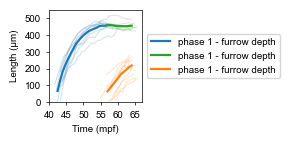

In [13]:
time_phase1_interp = np.linspace(42.5, 57, 20)
time_phase2_interp = np.linspace(57, 64, 10)
furrow_length_phase1_interp = []
furrow_length_phase2_interp = []
mem_septum_tip_phase2_length_interp = []

fig, ax = plt.subplots(figsize=[1.2, 1.2])
for i in replicates_info.index:
# for i in [replicates_info.index[-1]]:
    replicate = replicates_info.loc[i]
    # basic info
    rep = replicate.rep
    pixel_size, time_interval = replicate.pixel_size, replicate.time_interval
    m1, m2 = int(replicate.m1), int(replicate.m2)
    septum1, ck1 = int(replicate.septum1), int(replicate.ck1)
    i3 = int(replicate.i3)

    # time
    frame_phase1 = np.arange(ck1, septum1+1)
    frame_phase2 = np.arange(septum1, i3+1)
    time_phase1 = (frame_phase1 - m2)/(m1-m2)*(30-55) + 55
    time_phase2 = (frame_phase2 - m2)/(m1-m2)*(30-55) + 55
    time_phase12 = np.concatenate([time_phase1, time_phase2[1:]])

    # furrow length
    furrow_length = np.load('rep' + str(rep) + '\\furrow_length.npy')[1][2:]
    mem_septum_tip_phase2_length = np.load('rep' + str(rep) + '\\mem_septum_tip_phase2_length.npy')
    furrow_length_phase1 = furrow_length[time_phase12<=time_phase1[-1]]
    furrow_length_phase2 = furrow_length[time_phase12>=time_phase2[0]]

    furrow_length_phase1_new = np.interp(x=time_phase1_interp, xp=np.linspace(42.5, 57, len(furrow_length_phase1)), fp=furrow_length_phase1, left=np.nan, right=np.nan)
    furrow_length_phase2_new = np.interp(x=time_phase2_interp, xp=np.linspace(57, 64, len(furrow_length_phase2)), fp=furrow_length_phase2, left=np.nan, right=np.nan)
    mem_septum_tip_phase2_length_new = np.interp(x=time_phase2_interp, xp=np.linspace(57, 64, len(mem_septum_tip_phase2_length)), fp=mem_septum_tip_phase2_length, left=np.nan, right=np.nan)
    furrow_length_phase1_interp.append(furrow_length_phase1_new)
    furrow_length_phase2_interp.append(furrow_length_phase2_new)
    mem_septum_tip_phase2_length_interp.append(mem_septum_tip_phase2_length_new)

    lw, alpha = 0.8,  0.2
    ax.plot(time_phase1, furrow_length_phase1, color='tab:blue', lw=lw, zorder=-2, alpha=alpha)
    ax.plot(time_phase2, furrow_length_phase2, color='tab:green', lw=lw, zorder=-2, alpha=alpha)
    ax.plot(time_phase2, mem_septum_tip_phase2_length, color='tab:orange', lw=lw, zorder=-2, alpha=alpha)

    # plt.plot(time_phase1_interp, furrow_length_phase1_new, color='tab:blue')
    # plt.plot(time_phase2_interp, furrow_length_phase2_new, color='tab:green')

    # print(np.all(time_phase12==furrow_length[0][2:]))
furrow_length_phase1_interp = np.array(furrow_length_phase1_interp)
furrow_length_phase2_interp = np.array(furrow_length_phase2_interp)
mem_septum_tip_phase2_length_interp = np.array(mem_septum_tip_phase2_length_interp)

lw=1.6
ax.plot(time_phase1_interp, np.nanmean(furrow_length_phase1_interp, axis=0), color='tab:blue', lw=lw, zorder=1, label='phase 1 - furrow depth')
ax.plot(time_phase2_interp, np.nanmean(furrow_length_phase2_interp, axis=0), color='tab:green', lw=lw, zorder=1, label='phase 1 - furrow depth')
ax.plot(time_phase2_interp, np.nanmean(mem_septum_tip_phase2_length_interp, axis=0), color='tab:orange', lw=lw, zorder=1, label='phase 1 - furrow depth')

ax.set_ylim(0, 550)
ax.set_yticks(np.arange(0, 510, 100)) 
ax.set_xlim(40, 67)
ax.set_xticks(np.arange(40, 70, 5)) 
ax.set_xlabel('Time (mpf)', fontsize=7)
ax.set_ylabel('Length (\u03BCm)', fontsize=7)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=True, fontsize=7)
plt.savefig('furrow_length.svg')
plt.show()

## furrow curvature

(28,)
(27,)
(27,)
(30,)
(14,)
(14,)
(35,)
(30,)
(13,)


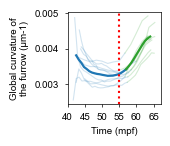

In [71]:
time_phase1_interp = np.linspace(42.5, 57, 20)
time_phase2_interp = np.linspace(57, 64, 10)
furrow_curv_phase1_interp = []
furrow_curv_phase2_interp = []
furrow_curv_phase2_septum_interp = []

fig, ax = plt.subplots(figsize=[1.2, 1.2])
for i in replicates_info.index:
    replicate = replicates_info.loc[i]
    # basic info
    rep = replicate.rep
    pixel_size, time_interval = replicate.pixel_size, replicate.time_interval
    m1, m2 = int(replicate.m1), int(replicate.m2)
    septum1, ck1 = int(replicate.septum1), int(replicate.ck1)
    i3 = int(replicate.i3)

    # time
    frame_phase1 = np.arange(ck1, septum1+1)
    frame_phase2 = np.arange(septum1, i3+1)
    time_phase1 = (frame_phase1 - m2)/(m1-m2)*(30-55) + 55
    time_phase2 = (frame_phase2 - m2)/(m1-m2)*(30-55) + 55
    time_phase12 = np.concatenate([time_phase1, time_phase2[1:]])

    # furrow curv
    furrow_curv = np.load('rep' + str(rep) + '\\furrow_curvature.npy')[1][2:]
    print(furrow_curv.shape)

    furrow_curv_phase1 = furrow_curv[time_phase12<=time_phase1[-1]]
    furrow_curv_phase2 = furrow_curv[time_phase12>=time_phase2[0]]

    furrow_curv_phase1_new = np.interp(x=time_phase1_interp, xp=np.linspace(42.5, 57, len(furrow_curv_phase1)), fp=furrow_curv_phase1, left=np.nan, right=np.nan)
    furrow_curv_phase2_new = np.interp(x=time_phase2_interp, xp=np.linspace(57, 64, len(furrow_curv_phase2)), fp=furrow_curv_phase2, left=np.nan, right=np.nan)
    furrow_curv_phase1_interp.append(furrow_curv_phase1_new)
    furrow_curv_phase2_interp.append(furrow_curv_phase2_new)

    # mem septum curv
    furrow_curv_phase2_septum = np.load('rep' + str(replicate.rep) + '\\mem_septum_tip_phase2_curv.npy')[:, 1]
    furrow_curv_phase2_septum_new = np.interp(x=time_phase2_interp, xp=np.linspace(57, 64, len(furrow_curv_phase2_septum)), fp=furrow_curv_phase2_septum, left=np.nan, right=np.nan)
    furrow_curv_phase2_septum_interp.append(furrow_curv_phase2_septum_new)



    lw, alpha = 0.8,  0.2
    ax.plot(time_phase1, furrow_curv_phase1, color='tab:blue', lw=lw, zorder=-2, alpha=alpha)
    ax.plot(time_phase2, furrow_curv_phase2, color='tab:green', lw=lw, zorder=-2, alpha=alpha)
    # try:
    #     ax.plot(time_phase2, furrow_curv_phase2_septum, color='tab:orange', lw=lw, zorder=-2, alpha=alpha)
    # except:
    #     ax.plot(time_phase2, furrow_curv_phase2_septum[:-1], color='tab:orange', lw=lw, zorder=-2, alpha=alpha)

    # plt.plot(time_phase1_interp, furrow_length_phase1_new, color='tab:blue')
    # plt.plot(time_phase2_interp, furrow_length_phase2_new, color='tab:green')

    # print(np.all(time_phase12==furrow_length[0][2:]))
furrow_curv_phase1_interp = np.array(furrow_curv_phase1_interp)
furrow_curv_phase2_interp = np.array(furrow_curv_phase2_interp)

lw=1.6
ax.plot(time_phase1_interp, np.nanmean(furrow_curv_phase1_interp, axis=0), color='tab:blue', lw=lw, zorder=1, label='phase 1 - furrow depth')
ax.plot(time_phase2_interp, np.nanmean(furrow_curv_phase2_interp, axis=0), color='tab:green', lw=lw, zorder=1, label='phase 1 - furrow depth')

ax.axvline(x = 55, color='r', linestyle='dotted')

# ax.set_ylim(0.0024, 0.00504)
# ax.set_yticks(np.arange(0, 600, 100)) 
ax.set_xlim(40, 67)
ax.set_xticks(np.arange(40, 70, 5)) 
ax.set_xlabel('Time (mpf)', fontsize=7)
ax.set_ylabel('Global curvature of\nthe furrow (\u03BCm-1)', fontsize=7)

# print(ax.get_ylim())

# ax.set_title('Length of the furrow (\u03BCm)', fontsize=12)
# ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=True, fontsize=12)
plt.savefig('furrow_curv.svg')
plt.show()
